In [7]:
%matplotlib inline

import gymnasium as gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [8]:
env = WindyGridworldEnv()

In [9]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [23]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

In [17]:
Q, stats = sarsa(env, 200)

Episode 200/200.

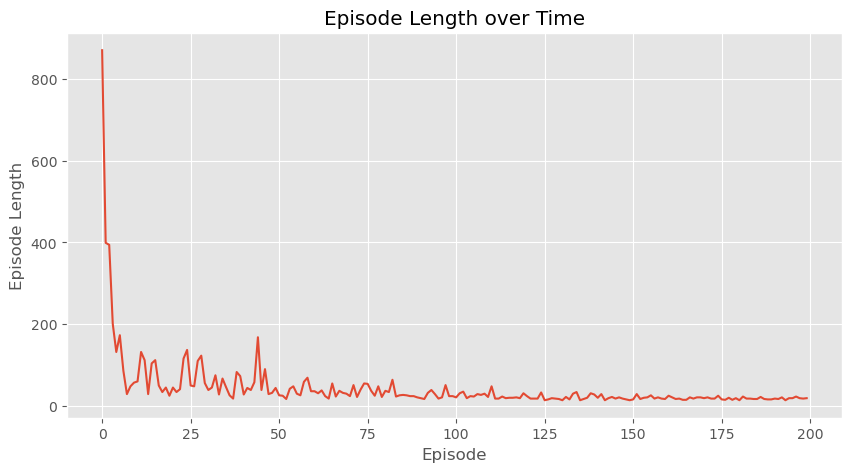

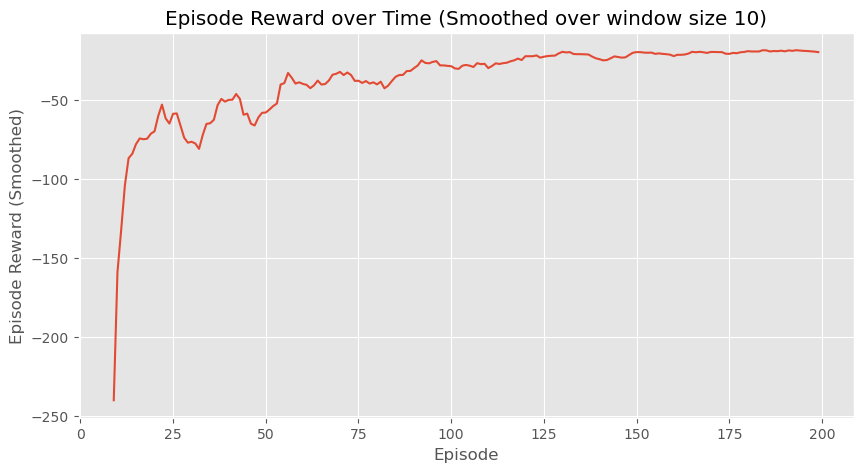

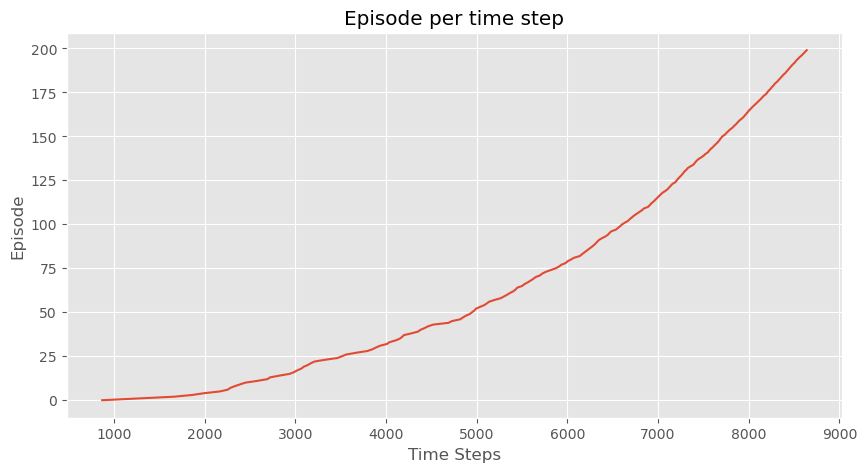

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [18]:
plotting.plot_episode_stats(stats)

## now try the offline policy result:

In [19]:
# train Q again with more episodes:
Q, stats = sarsa(env, 2000)

Episode 2000/2000.

In [20]:
def always_act_best( Q, nA):
    """
    give a Q function, return a state to action that always acts by maximizing.
    Assumption required:
    for every state, Q[state] is of length nA  
    
    """

    def policy_fn(observation):
        best_action = np.argmax(Q[observation])
        return best_action
    return policy_fn


In [21]:
Q

defaultdict(<function __main__.sarsa.<locals>.<lambda>()>,
            {30: array([-21.78730219, -18.78433076, -20.35699049, -20.24470346]),
             40: array([-21.8185672 , -19.0746549 , -20.59273044, -20.38625113]),
             20: array([-20.01459498, -19.55650046, -20.51243503, -20.66029257]),
             10: array([-19.68408039, -19.68100713, -21.05951809, -19.67735386]),
             0: array([-19.39561483, -19.35869149, -19.2788641 , -19.925807  ]),
             1: array([-19.41741672, -18.34556802, -19.63063205, -19.34045701]),
             11: array([-19.69822128, -19.62505443, -20.22466436, -19.36215183]),
             21: array([-19.85500519, -17.14864319, -20.43908398, -20.11210219]),
             2: array([-18.87472822, -15.84118094, -18.31728089, -18.12297141]),
             3: array([-18.00868776, -16.16988945, -18.18351189, -18.24296189]),
             4: array([-15.71694134, -12.66745095, -15.93132299, -16.49128991]),
             5: array([-15.17696718, -11.558

starting running....
Episode 1000/1000. Number of steps to end episode is 15:

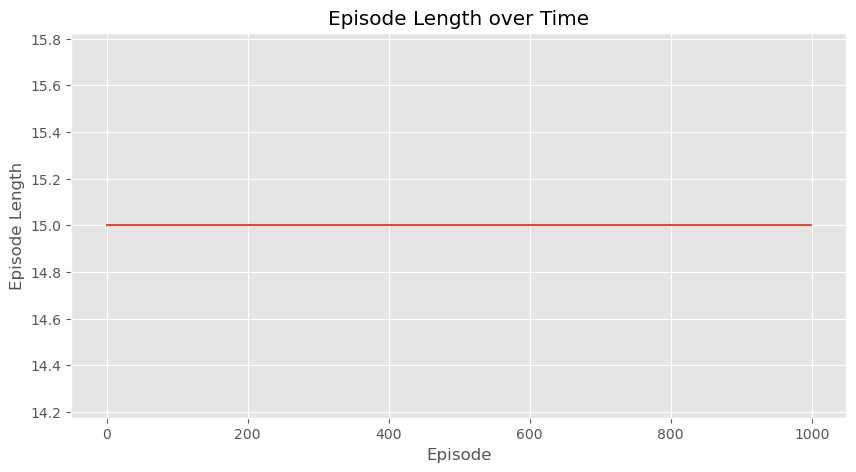

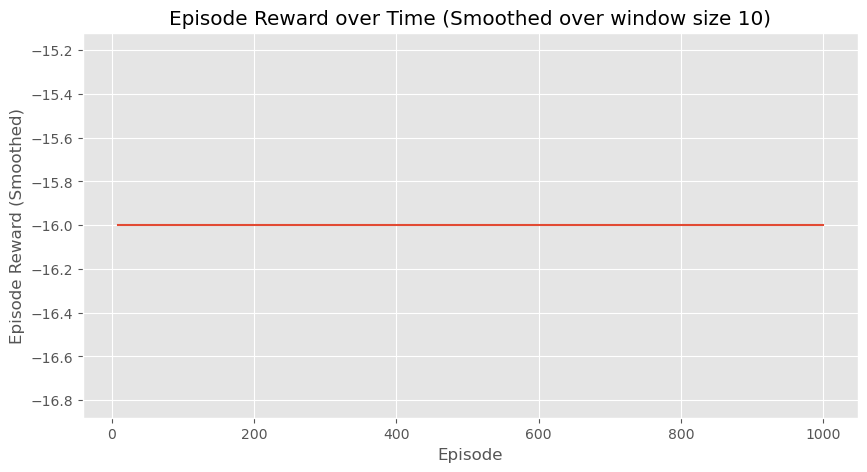

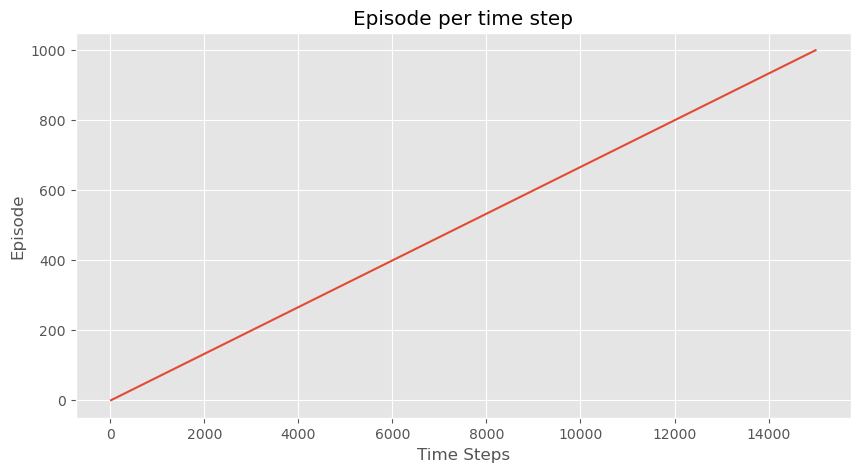

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [22]:

num_of_epi_to_try = 1000

# keep track of all results:

stats_act_best = plotting.EpisodeStats(
    episode_lengths= np.zeros(num_of_epi_to_try),
    episode_rewards= np.zeros(num_of_epi_to_try)
    )

# need to run one of the above training first:
best_policy = always_act_best(Q, env.action_space.n)

print('starting running....')

for epi in range(num_of_epi_to_try):


    state = env.reset()
    for t in itertools.count():
        action = best_policy(state)
        next_state, reward, done, _ = env.step(action)
        
        #update statistics:
        stats_act_best.episode_rewards[epi] += reward
        stats_act_best.episode_lengths[epi] =t
        state = next_state
        if done:
            break

    print("\rEpisode {}/{}. Number of steps to end episode is {}:".format(epi + 1, num_of_epi_to_try, t), end="")

    print("\rEpisode {}/{}.".format(epi+ 1, num_of_epi_to_try), end="")
    sys.stdout.flush()

plotting.plot_episode_stats(stats_act_best)



In [23]:

state = env.reset()
env.render()
cum_reward = 0
# acting until the end of one episode:
print('Q at starting state: ', Q[state])
print(np.argmax(Q[state]))
# action = best_policy(state)


while True:

    action = best_policy(state)
    next_state, reward, done, _ = env.step(action)
    print('action: ', action)
    cum_reward += reward
    state = next_state
    env.render()
    if done:
        print('The end of episode. Total reward is', cum_reward)
        break

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

Q at starting state:  [-19.67775772 -18.71502575 -20.20604849 -19.09567912]
1
action:  1
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

action:  1
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

action:  1
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

action:  1
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o